In [1]:
import re
from collections import Counter
import pickle
import numpy as np
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from scipy.sparse import csr_matrix, hstack
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
def remove_url(text):
    pattern = "((http|ftp|https):\/\/)?([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w.,@?^=%&:\/~+#-])?"
    return re.sub(pattern, "", text)

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    tokens = nltk.word_tokenize(text)
    filtered_sentence = " ".join([w for w in tokens if not w in stop_words])
    return filtered_sentence

def is_too_short(text):
    tokens = nltk.word_tokenize(text)
    return len(tokens) <= 3

In [3]:
def divide_text(text, n):
    tokens = nltk.word_tokenize(text)
    spilting_length = len(tokens) / n
    out = []
    x = 0
    for i in range(n):
        str_list = tokens[x:int(x+spilting_length)]
        string = " ".join(str_list)
        out.append(string)
        x = int(x+spilting_length)
    return out

def get_sentiment(arr):
    n = len(arr)
    polar = []
    for i in range(n):
        analysis = TextBlob(arr[i])
        polar.append(analysis.sentiment.polarity)
    return polar

def find_sentiment(arr):
    n = len(arr)
    out = np.empty((len(arr), 6))
    for i in range(len(arr)):
        analysis = TextBlob(arr[i])
        uni_polar = analysis.sentiment.polarity
        string_list = divide_text(arr[i], 2)
        bi_polar = get_sentiment(string_list)
        string_list = divide_text(arr[i], 3)
        tri_polar = get_sentiment(string_list)
        out[i] = [uni_polar, bi_polar[0], bi_polar[1], tri_polar[0], tri_polar[1], tri_polar[2]]
    return out

In [4]:
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

In [5]:
def pos_tag_finder(text):
    tokens = nltk.word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    counts = Counter(tag for word,tag in tags)
    total = sum(counts.values())
    return dict((word, float(count)/total) for word,count in counts.items())

def get_pos_features(arr):
    out = np.array([])
    for i in range(len(arr)):
        pos_tags = pos_tag_finder(arr[i])
        out = np.append(out, pos_tags)
    return out

In [6]:
dataset = load_files('container/', encoding="utf8", decode_error="replace")

In [7]:
X = np.array([])
y = np.array([])
for i in range(len(dataset.data)):
    if not is_too_short(dataset.data[i]):
        noisless_text = remove_url(str(dataset.data[i]))
        noisless_text = remove_stopwords(noisless_text)
        X = np.append(X, noisless_text)
        if dataset.target[i] == 0:
            y = np.append(y, 'notsarc')
        else:
            y = np.append(y, 'sarc')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [9]:
sentiment_train = csr_matrix(find_sentiment(X_train))
sentiment_test = csr_matrix(find_sentiment(X_test))

In [10]:
stemmer = PorterStemmer()

In [11]:
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words='english', ngram_range=(1, 5), max_features=1939)
tfs_train = tfidf.fit_transform(X_train)
tfs_test = tfidf.transform(X_test)

In [12]:
vec = DictVectorizer()

pos_train = vec.fit_transform(get_pos_features(X_train))
pos_test = vec.transform(get_pos_features(X_test))

In [13]:
lda = LatentDirichletAllocation(n_topics=10, learning_method='online')

topic_train = lda.fit_transform(tfs_train)
topic_test = lda.transform(tfs_test)

In [14]:
final_train = hstack([sentiment_train, tfs_train, pos_train, topic_train])
final_test = hstack([sentiment_test, tfs_test, pos_test, topic_test])

In [15]:
logistic_clf = LogisticRegression(C=0.2)
logistic_clf = logistic_clf.fit(final_train, y_train)
predict = logistic_clf.predict(final_test)
print(accuracy_score(y_test, predict))

0.581218274112


In [16]:
svm_clf = SVC(C=4, gamma=1.3)
svm_clf = svm_clf.fit(final_train, y_train)
predict = svm_clf.predict(final_test)
print(accuracy_score(y_test, predict))

0.558375634518


In [17]:
linear_svm_clf = LinearSVC(C=0.1)
linear_svm_clf = linear_svm_clf.fit(final_train, y_train)
predict = linear_svm_clf.predict(final_test)
print(accuracy_score(y_test, predict))

0.591370558376


In [18]:
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf = rf_clf.fit(final_train, y_train)
predict = rf_clf.predict(final_test)
print(accuracy_score(y_test, predict))

0.571065989848


In [19]:
logistic_clf = LogisticRegression()
logistic_clf = logistic_clf.fit(final_train, y_train)
predict = logistic_clf.predict(final_test)
print(accuracy_score(y_test, predict))

0.596446700508


In [20]:
svm_clf = SVC()
svm_clf = svm_clf.fit(final_train, y_train)
predict = svm_clf.predict(final_test)
print(accuracy_score(y_test, predict))

0.497461928934


In [21]:
linear_svm_clf = LinearSVC()
linear_svm_clf = linear_svm_clf.fit(final_train, y_train)
predict = linear_svm_clf.predict(final_test)
print(accuracy_score(y_test, predict))

0.565989847716


In [22]:
count = 0
for i in range(len(y_train)):
    if y_train[i] == 'sarc':
        count += 1
print(count, len(y_train) - count)

796 779


In [23]:
c_range = np.linspace(0.001, 0.1, num=10)
c_range = np.append(c_range, np.linspace(0.1, 2, num=20))
c_range = np.append(c_range, np.linspace(2, 10, num=30))
acc = np.array([])
for i in range(len(c_range)):
    logistic_clf = LogisticRegression(C=c_range[i])
    logistic_clf = logistic_clf.fit(final_train, y_train)
    predict = logistic_clf.predict(final_test)
    acc = np.append(acc, [accuracy_score(y_test, predict), c_range[i]])

In [24]:
maxv = 0
c = 0
for i in range(0, len(acc), 2):
    if maxv < acc[i]:
        maxv = acc[i]
        c = acc[i+1]
print(maxv)
print(c)

0.598984771574
0.6


In [25]:
print(acc[22])

0.581218274112


In [26]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB
gs_clf = BernoulliNB()
gs_clf = gs_clf.fit(final_train.toarray(), y_train)
predict = gs_clf.predict(final_test.toarray())
print(accuracy_score(y_test, predict))

0.621827411168


In [27]:
gs_clf = GaussianNB()
gs_clf = gs_clf.fit(final_train.toarray(), y_train)
predict = gs_clf.predict(final_test.toarray())
print(accuracy_score(y_test, predict))

0.532994923858


In [28]:
c_range = np.array([1.2, 2, 3, 4, 5, 6])
gamma_range = np.array([0.9, 1.3])
acc = np.array([])
for i in range(len(c_range)):
    for j in range(len(gamma_range)):
        svm_clf = SVC(C=c_range[i], gamma=gamma_range[j])
        svm_clf = svm_clf.fit(final_train, y_train)
        predict = svm_clf.predict(final_test)
        acc = np.append(acc, [accuracy_score(y_test, predict), c_range[i], gamma_range[j]])
        if accuracy_score(y_test, predict) >= 0.60:
            print([accuracy_score(y_test, predict), c_range[i], gamma_range[j]])

In [29]:
maxv = 0
c = 0
gamma = 0
for i in range(0, len(acc), 3):
    if maxv < acc[i]:
        maxv = acc[i]
        c = acc[i+1]
        gamma = acc[i+2]
print(maxv)
print(c)
print(gamma)

0.560913705584
1.2
0.9


In [30]:
c_range = np.linspace(0.001, 0.1, num=10)
c_range = np.append(c_range, np.linspace(0.1, 2, num=20))
c_range = np.append(c_range, np.linspace(2, 10, num=30))
acc = np.array([])
for i in range(len(c_range)):
    lsvm_clf = LinearSVC(C=c_range[i])
    lsvm_clf = lsvm_clf.fit(final_train, y_train)
    predict = lsvm_clf.predict(final_test)
    acc = np.append(acc, [accuracy_score(y_test, predict), c_range[i]])

In [31]:
maxv = 0
c = 0
for i in range(0, len(acc), 2):
    if maxv < acc[i]:
        maxv = acc[i]
        c = acc[i+1]
print(maxv)
print(c)

0.598984771574
0.067


In [32]:
import matplotlib.pyplot as plt

In [33]:
dataset.target

array([0, 1, 0, ..., 1, 0, 0])

In [34]:
y_plt = np.array([])
for i in range(len(y_train)):
    if y_train[i] == 'sarc':
        y_plt = np.append(y_plt, 0)
    else:
        y_plt = np.append(y_plt, 1)

In [35]:
y_plt.shape

(1575,)

In [36]:
final_train.shape

(1575, 2000)

In [37]:
plt.scatter(final_train.toarray().T[0], final_train.toarray().T[1], y_plt)

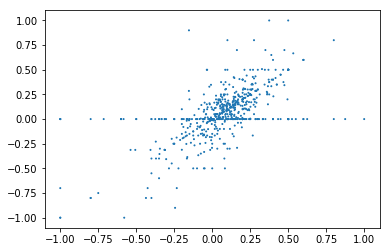

In [38]:
plt.show()

In [39]:
plt.scatter(final_train.toarray().T[2], final_train.toarray().T[3], y_plt)

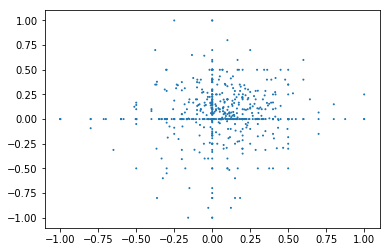

In [40]:
plt.show()

In [41]:
plt.scatter(final_train.toarray().T[4], final_train.toarray().T[5], y_plt)

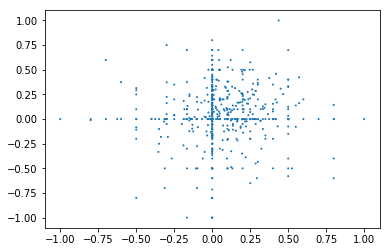

In [42]:
plt.show()